<a href="https://colab.research.google.com/github/JesiyaFernandes/heartattackrisk/blob/main/B3_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import pandas as pd

json_path = "/content/drive/MyDrive/Data_Set_China/data_info.json"   # update path
csv_path  = "/content/drive/MyDrive/Data_Set_China/data_csv.csv"

with open(json_path, "r", encoding="utf-8") as f:
    raw = json.load(f)   # raw is a dict: { "2491006": { ... }, "3730004": { ... }, ... }

rows = []

for patient_id, info in raw.items():
    # common fields
    gender    = info.get("gender")
    thickness = info.get("thickness")
    label     = info.get("label")   # 0/1 – this is your risk label
    group     = info.get("group")
    true_age  = info.get("True_age")
    age_norm  = info.get("age")     # normalized age if present

    # right eye
    if "right_eye" in info and info["right_eye"]:
        rows.append({
            "PatientID": patient_id,
            "eye": "R",
            "filename": info["right_eye"],
            "gender": gender,
            "thickness": thickness,
            "label": label,
            "group": group,
            "True_age": true_age,
            "age_norm": age_norm,
        })

    # left eye
    if "left_eye" in info and info["left_eye"]:
        rows.append({
            "PatientID": patient_id,
            "eye": "L",
            "filename": info["left_eye"],
            "gender": gender,
            "thickness": thickness,
            "label": label,
            "group": group,
            "True_age": true_age,
            "age_norm": age_norm,
        })

# Create DataFrame and save to CSV
df = pd.DataFrame(rows)
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)
print(df.head())


Saved: /content/drive/MyDrive/Data_Set_China/data_csv.csv
  PatientID eye       filename  gender  thickness  label  group  True_age  \
0   2491006   R  2491006_R.png       0        0.8      0      1        63   
1   2491006   L  2491006_L.png       0        0.8      0      1        63   
2   3730004   R  3730004_R.png       1        1.2      1      1        61   
3   3730004   L  3730004_L.png       1        1.2      1      1        61   
4   3730006   R  3730006_R.png       1        1.2      1      1        64   

   age_norm  
0  0.684932  
1  0.684932  
2  0.657534  
3  0.657534  
4  0.698630  


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
"""
Preprocessing pipeline for retinal fundus dataset
- CSV cleaning and encoding
- Patient-level train/val/test split
- Image cropping, resizing, and normalization-ready storage

Author: <your name>
"""

import os
from pathlib import Path
import shutil
import random

import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------------
# Configuration
# -----------------------------
DATA_ROOT = Path("/content/drive/MyDrive/Data_Set_China/Fundus_CIMT_2903_cropped_512")  # folder containing images
CSV_PATH = Path("/content/drive/MyDrive/Data_Set_China/data_csv.csv")               # your CSV file
OUTPUT_ROOT = Path("/content/drive/MyDrive/Data_Set_China/processed_dataset")

IMAGE_EXT = ".png"
IMAGE_SIZE = 384              # final square size (e.g. 224, 299, 384)
RANDOM_SEED = 42
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15              # test will be 1 - TRAIN_RATIO - VAL_RATIO

# Column names in your CSV (adjust if different)
COL_PATIENT_ID = "PatientID"
COL_FILENAME = "filename"
COL_EYE = "eye"               # 'L' or 'R'
COL_GENDER = "gender"         # 0/1 or M/F
COL_LABEL = "label"           # risk label
COL_GROUP = "group"           # optional extra grouping

# -----------------------------
# Utility functions
# -----------------------------

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

def load_and_clean_csv(csv_path: Path) -> pd.DataFrame:
    """Load CSV, drop duplicates/NA, standardize dtypes, and attach image paths."""
    df = pd.read_csv(csv_path)

    # Basic cleaning
    df = df.drop_duplicates()
    df = df.dropna(subset=[COL_PATIENT_ID, COL_FILENAME])

    # Ensure types
    df[COL_PATIENT_ID] = df[COL_PATIENT_ID].astype(str)
    df[COL_FILENAME] = df[COL_FILENAME].astype(str)

    # Standardize eye column if present
    if COL_EYE in df.columns:
        df[COL_EYE] = df[COL_EYE].str.upper().str.strip()

    # Encode gender if text; if already 0/1, this will have no effect
    if COL_GENDER in df.columns and not np.issubdtype(df[COL_GENDER].dtype, np.number):
        df[COL_GENDER] = (
            df[COL_GENDER]
            .str.upper()
            .str.strip()
            .map({"M": 1, "MALE": 1, "F": 0, "FEMALE": 0})
        )

    # Attach full image path
    df["image_path"] = df[COL_FILENAME].apply(
        lambda x: str(DATA_ROOT / x)
    )

    # Filter rows where image file actually exists
    df["image_exists"] = df["image_path"].apply(os.path.exists)
    missing = df[~df["image_exists"]]
    if len(missing) > 0:
        print(f"Warning: {len(missing)} entries without images will be dropped.")
        df = df[df["image_exists"]]

    df = df.drop(columns=["image_exists"])

    return df


def crop_fundus_circle(img: np.ndarray, padding: int = 10) -> np.ndarray:
    """
    Simple cropping of fundus images:
    - Convert to gray
    - Threshold to find the circular fundus region
    - Crop to bounding box with small padding.
    Inspired by common fundus pre-processing approaches. [web:23][web:27][web:28]
    """
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Normalize and threshold
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(gray_blur, 10, 255, cv2.THRESH_BINARY)

    # Find bounding box of the non-zero region
    coords = cv2.findNonZero(mask)
    if coords is None:
        return img  # fallback: return original

    x, y, w, h = cv2.boundingRect(coords)

    x0 = max(x - padding, 0)
    y0 = max(y - padding, 0)
    x1 = min(x + w + padding, img.shape[1])
    y1 = min(y + h + padding, img.shape[0])

    cropped = img[y0:y1, x0:x1]
    return cropped


def preprocess_image(path: str, image_size: int = 384) -> np.ndarray:
    """
    Load an image from disk, crop border, resize to fixed size.
    Returns BGR uint8 image; normalization will typically be done in the
    dataloader before feeding into the network. [web:28][web:31][web:37]
    """
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")

    img = crop_fundus_circle(img, padding=10)
    img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_AREA)

    return img


def patient_level_split(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split dataframe into train/val/test at patient level to avoid leakage. [web:29][web:32][web:35][web:41]
    """
    patients = df[COL_PATIENT_ID].unique()
    train_patients, temp_patients = train_test_split(
        patients, test_size=(1 - TRAIN_RATIO), random_state=RANDOM_SEED, shuffle=True
    )

    val_size_rel = VAL_RATIO / (1 - TRAIN_RATIO)
    val_patients, test_patients = train_test_split(
        temp_patients, test_size=(1 - val_size_rel), random_state=RANDOM_SEED, shuffle=True
    )

    train_df = df[df[COL_PATIENT_ID].isin(train_patients)].reset_index(drop=True)
    val_df = df[df[COL_PATIENT_ID].isin(val_patients)].reset_index(drop=True)
    test_df = df[df[COL_PATIENT_ID].isin(test_patients)].reset_index(drop=True)

    print(f"Patients: train={len(train_patients)}, val={len(val_patients)}, test={len(test_patients)}")
    print(f"Images:   train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

    return train_df, val_df, test_df


def save_split_and_images(
    df: pd.DataFrame,
    split_name: str,
    output_root: Path,
    image_size: int = 384,
    limit: int | None = None,
):
    """
    Preprocess and copy images into structured folders:
        output_root/split_name/images/
    Also save the CSV with updated relative paths.
    """
    split_root = output_root / split_name
    img_out_dir = split_root / "images"
    split_root.mkdir(parents=True, exist_ok=True)
    img_out_dir.mkdir(parents=True, exist_ok=True)

    processed_paths = []
    rows = df if limit is None else df.iloc[:limit].copy()

    for idx, row in rows.iterrows():
        src = row["image_path"]
        # Preserve filename
        fname = os.path.basename(src)
        dst = img_out_dir / fname

        try:
            img = preprocess_image(src, image_size=image_size)
            cv2.imwrite(str(dst), img)
            processed_paths.append(str(dst.relative_to(split_root)))
        except Exception as e:
            print(f"[{split_name}] Skipping {src}: {e}")
            processed_paths.append(None)

    rows["processed_path"] = processed_paths
    rows = rows.dropna(subset=["processed_path"])

    # Save CSV for this split
    csv_out = split_root / f"{split_name}_metadata.csv"
    rows.to_csv(csv_out, index=False)
    print(f"Saved {len(rows)} records for {split_name} to {csv_out}")


# -----------------------------
# Main entrypoint
# -----------------------------
if __name__ == "__main__":
    set_seed(RANDOM_SEED)

    # 1. Load & clean CSV
    df_all = load_and_clean_csv(CSV_PATH)
    print(f"Total valid rows after cleaning: {len(df_all)}")

    # 2. Optional: basic sanity checks
    if COL_LABEL in df_all.columns:
        print("Label distribution:")
        print(df_all[COL_LABEL].value_counts(dropna=False))

    # 3. Patient-level split
    train_df, val_df, test_df = patient_level_split(df_all)

    # 4. Save splits and preprocessed images
    #    Remove `limit` argument to process the full dataset.
    OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
    save_split_and_images(train_df, "train", OUTPUT_ROOT, image_size=IMAGE_SIZE)
    save_split_and_images(val_df, "val", OUTPUT_ROOT, image_size=IMAGE_SIZE)
    save_split_and_images(test_df, "test", OUTPUT_ROOT, image_size=IMAGE_SIZE)

    print("Preprocessing completed.")


Total valid rows after cleaning: 5806
Label distribution:
label
1    4108
0    1698
Name: count, dtype: int64
Patients: train=2032, val=435, test=436
Images:   train=4064, val=870, test=872
Saved 4064 records for train to /content/drive/MyDrive/Data_Set_China/processed_dataset/train/train_metadata.csv
Saved 870 records for val to /content/drive/MyDrive/Data_Set_China/processed_dataset/val/val_metadata.csv
Saved 872 records for test to /content/drive/MyDrive/Data_Set_China/processed_dataset/test/test_metadata.csv
Preprocessing completed.


In [ ]:
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

import cv2

# -----------------------------
# Configuration
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Fix: Added missing '/' in the path
PROCESSED_ROOT = Path("/content/drive/MyDrive/Data_Set_China/processed_dataset")
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_SIZE = 300
FEATURE_DIM = 1536  # EfficientNet-B0 last conv feature size

# -----------------------------
# Dataset and transforms
# -----------------------------

class FundusImageOnlyDataset(Dataset):
    def __init__(self, images_dir: Path, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.image_paths = sorted([
            p for p in images_dir.glob("*")
            if p.suffix.lower() in [".png", ".jpg", ".jpeg"]
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = cv2.imread(str(path), cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(str(path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            img = self.transform(img)

        return img, str(path.name)

# ImageNet normalization for pretrained EfficientNet. [web:30][web:62]
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


# -----------------------------
# Feature extractor model
# -----------------------------

def build_feature_extractor():
    """
    EfficientNet-B3 pretrained on ImageNet, used only as feature extractor
    (classifier head removed).
    """
    weights = EfficientNet_B3_Weights.IMAGENET1K_V1
    model = efficientnet_b3(weights=weights)
    model.classifier = nn.Identity()
    model.eval()
    return model.to(DEVICE)


# -----------------------------
# Extraction loop
# -----------------------------

def extract_features_from_folder(split_name: str):
    images_dir = PROCESSED_ROOT / split_name / "images"
    dataset = FundusImageOnlyDataset(images_dir, transform=image_transform)
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )

    model = build_feature_extractor()

    all_features = []
    all_filenames = []

    with torch.no_grad():
        for imgs, names in tqdm(dataloader, desc=f"{split_name} feature extraction"):
            imgs = imgs.to(DEVICE, non_blocking=True)
            feats = model(imgs)               # (B, FEATURE_DIM)
            feats = feats.cpu().numpy()

            all_features.append(feats)
            all_filenames.extend(names)

    # Only concatenate if there are features to avoid ValueError
    if len(all_features) > 0:
        all_features = np.concatenate(all_features, axis=0)
    else:
        print(f"Warning: No features extracted for {split_name}. Check image_dir: {images_dir}")
        all_features = np.array([]) # Ensure it's an empty numpy array

    # Save
    split_root = PROCESSED_ROOT / split_name
    split_root.mkdir(parents=True, exist_ok=True)

    feat_path = split_root / f"{split_name}_features.npy"
    names_path = split_root / f"{split_name}_filenames.npy"

    if all_features.size > 0:
        np.save(feat_path, all_features)
        np.save(names_path, np.array(all_filenames))
    else:
        print(f"Skipping save for {split_name} as no features were extracted.")

    print(f"{split_name}: features shape = {all_features.shape}")
    print(f"Saved features to {feat_path}")
    print(f"Saved filenames to {names_path}")


if __name__ == "__main__":
    for split in ["train", "val", "test"]:
        extract_features_from_folder(split)
    print("Done.")

train feature extraction:   0%|          | 0/127 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
train feature extraction: 100%|██████████| 127/127 [20:38<00:00,  9.75s/it]


train: features shape = (4064, 1536)
Saved features to /content/drive/MyDrive/Data_Set_China/processed_dataset/train/train_features.npy
Saved filenames to /content/drive/MyDrive/Data_Set_China/processed_dataset/train/train_filenames.npy


val feature extraction: 100%|██████████| 28/28 [02:31<00:00,  5.39s/it]


val: features shape = (870, 1536)
Saved features to /content/drive/MyDrive/Data_Set_China/processed_dataset/val/val_features.npy
Saved filenames to /content/drive/MyDrive/Data_Set_China/processed_dataset/val/val_filenames.npy


test feature extraction: 100%|██████████| 28/28 [02:15<00:00,  4.83s/it]


test: features shape = (872, 1536)
Saved features to /content/drive/MyDrive/Data_Set_China/processed_dataset/test/test_features.npy
Saved filenames to /content/drive/MyDrive/Data_Set_China/processed_dataset/test/test_filenames.npy
Done.


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


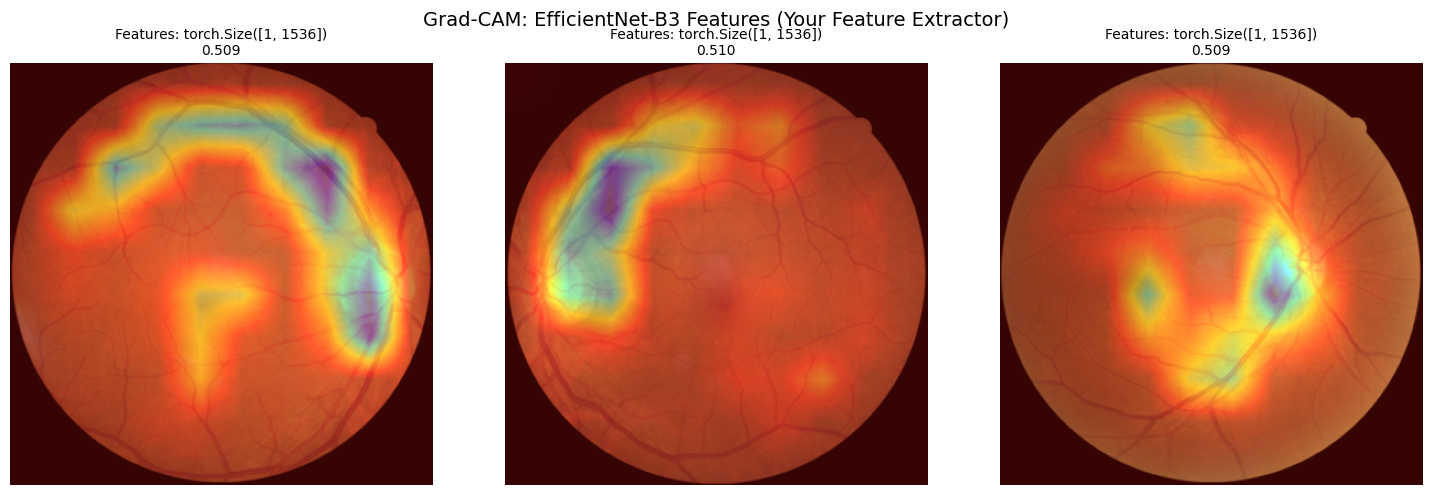

✅ Grad-CAM using your exact feature extractor!
Feature shape: torch.Size([1, 1536])


In [ ]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import torch
import torch.nn as nn # Added this import
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
import numpy as np

# ✅ YOUR CONFIG (exact match)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PROCESSED_ROOT = Path("/content/drive/MyDrive/Data_Set_China/processed_dataset")
IMAGE_SIZE = 300

# ✅ YOUR EXACT TRANSFORM (copied from feature extractor)
image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# ✅ YOUR EXACT FEATURE EXTRACTOR (copied from your code)
def build_feature_extractor():
    weights = EfficientNet_B3_Weights.IMAGENET1K_V1
    model = efficientnet_b3(weights=weights)
    model.classifier = nn.Identity()  # Remove classifier for features
    model.eval()
    return model.to(DEVICE)

# ✅ GRADCAM CLASS (target='features.8' for B3)
class GradCAM:
    def __init__(self, model, target_layer_name='features.8'):  # B3 last conv
        self.model = model
        self.gradients = None
        self.activations = None
        self.target_layer = dict(model.named_modules())[target_layer_name]
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, img_tensor):
        self.model.eval()
        self.model.zero_grad()
        features = self.model(img_tensor)  # Your exact feature output (B, 1536)

        # ✅ Fake "score" for backward pass (use any dimension)
        score = features[:, 0]  # Use first feature dimension
        score.backward()

        weights = torch.mean(self.gradients, dim=[2, 3], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()
        cam = F.relu(cam)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam.cpu()

# ==============================
# RUN GRADCAM ON YOUR DATA ✅
# ==============================
model = build_feature_extractor()  # Your exact model!
gradcam = GradCAM(model)

# Your test images
test_dir = PROCESSED_ROOT / "test" / "images"
test_images = list(test_dir.glob("*.png"))[:3]

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, img_path in enumerate(test_images):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_tensor = image_transform(img).unsqueeze(0).to(DEVICE)

    # Your feature extraction
    features = model(img_tensor)
    pred_score = torch.sigmoid(features.mean(dim=1)).item()  # Demo score

    # Generate CAM
    cam = gradcam.generate(img_tensor)

    # Overlay (match your image size)
    cam_resized = cv2.resize(cam.numpy(), (img.shape[1], img.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    axs[i].imshow(overlay)
    axs[i].set_title(f"Features: {features.shape}\n{pred_score:.3f}", fontsize=10)
    axs[i].axis('off')

plt.suptitle("Grad-CAM: EfficientNet-B3 Features (Your Feature Extractor)", fontsize=14)
plt.tight_layout()
plt.savefig("gradcam_features.png", dpi=300, bbox_inches='tight')
plt.show()

print("✅ Grad-CAM using your exact feature extractor!")
print(f"Feature shape: {features.shape}")  # Should be torch.Size([1, 1536])


In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# Config
# -----------------------------
CSV_PATH = Path("/content/drive/MyDrive/Data_Set_China/data_csv.csv")
OUT_CSV_PATH = Path("/content/drive/MyDrive/Data_Set_China/data_csv_normalized.csv")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
NUM_EPOCHS = 30
LR = 1e-3
LATENT_DIM = 8  # 8D normalized features for B3 pipeline

NUM_COLS = ["gender", "thickness", "True_age", "age_norm"]

# -----------------------------
# Dataset (unchanged)
# -----------------------------
class TabularFeatureDataset(Dataset):
    def __init__(self, x: np.ndarray):
        self.x = x.astype(np.float32)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx]

# -----------------------------
# FC autoencoder normalizer (unchanged)
# -----------------------------
class TabularNormalizer(nn.Module):
    def __init__(self, in_dim: int, latent_dim: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, in_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        recon = self.decoder(z)
        return z, recon

# -----------------------------
# Main (FIXED)
# -----------------------------
if __name__ == "__main__":
    # 1) Load CSV and extract numeric features
    df = pd.read_csv(CSV_PATH)
    x = df[NUM_COLS].values
    in_dim = x.shape[1]
    print(f"Input shape: {x.shape} | Features: {NUM_COLS}")

    dataset = TabularFeatureDataset(x)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

    # 2) Train normalizer (autoencoder)
    model = TabularNormalizer(in_dim, LATENT_DIM).to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    model.train()
    for epoch in range(NUM_EPOCHS):
        epoch_loss = 0.0
        for batch in loader:
            batch = batch.to(DEVICE)
            z, recon = model(batch)
            loss = criterion(recon, batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch.size(0)

        epoch_loss /= len(dataset)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, recon MSE: {epoch_loss:.6f}")

    # 3) Get normalized features for all rows (MOVED OUTSIDE LOOP)
    print("\n🔄 Encoding all rows...")
    full_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
    model.eval()
    all_z = []

    with torch.no_grad():
        for batch in tqdm(full_loader, desc="Encoding all rows"):
            batch = batch.to(DEVICE)
            z, _ = model(batch)
            all_z.append(z.cpu().numpy())

    all_z = np.concatenate(all_z, axis=0)
    print(f"✅ Encoded shape: {all_z.shape}")

    # 4) Save back to CSV
    for i in range(LATENT_DIM):
        df[f"f{i}"] = all_z[:, i]

    df.to_csv(OUT_CSV_PATH, index=False)
    print(f"✅ Saved {LATENT_DIM}D normalized features to {OUT_CSV_PATH}")
    print(f"📊 New columns: f0-f{LATENT_DIM-1}")
    print("🎯 Ready for B3 multi-modal training!")


Input shape: (5806, 4) | Features: ['gender', 'thickness', 'True_age', 'age_norm']
Epoch 1/30, recon MSE: 609.889414
Epoch 2/30, recon MSE: 594.793264
Epoch 3/30, recon MSE: 562.607111
Epoch 4/30, recon MSE: 495.963864
Epoch 5/30, recon MSE: 372.116427
Epoch 6/30, recon MSE: 208.455954
Epoch 7/30, recon MSE: 101.755145
Epoch 8/30, recon MSE: 72.791438
Epoch 9/30, recon MSE: 51.333195
Epoch 10/30, recon MSE: 35.410363
Epoch 11/30, recon MSE: 22.948019
Epoch 12/30, recon MSE: 19.421627
Epoch 13/30, recon MSE: 16.594712
Epoch 14/30, recon MSE: 14.147737
Epoch 15/30, recon MSE: 10.736207
Epoch 16/30, recon MSE: 9.338505
Epoch 17/30, recon MSE: 7.987232
Epoch 18/30, recon MSE: 7.223590
Epoch 19/30, recon MSE: 6.389347
Epoch 20/30, recon MSE: 6.135684
Epoch 21/30, recon MSE: 5.113895
Epoch 22/30, recon MSE: 4.986547
Epoch 23/30, recon MSE: 4.483598
Epoch 24/30, recon MSE: 3.967611
Epoch 25/30, recon MSE: 3.630904
Epoch 26/30, recon MSE: 3.471727
Epoch 27/30, recon MSE: 2.846663
Epoch 28/30, 

Encoding all rows: 100%|██████████| 23/23 [00:00<00:00, 772.61it/s]

✅ Encoded shape: (5806, 8)


✅ Saved 8D normalized features to /content/drive/MyDrive/Data_Set_China/data_csv_normalized.csv
📊 New columns: f0-f7
🎯 Ready for B3 multi-modal training!


In [ ]:
!pip install lion-pytorch


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Tuple

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

# -----------------------------
# Paths and config (B3 Updated)
# -----------------------------
BASE = Path("/content/drive/MyDrive/Data_Set_China/processed_dataset")  # Fixed path

TRAIN_FEATS = BASE / "train" / "train_features.npy"
TRAIN_NAMES = BASE / "train" / "train_filenames.npy"
VAL_FEATS   = BASE / "val" / "val_features.npy"
VAL_NAMES   = BASE / "val" / "val_filenames.npy"
TEST_FEATS  = BASE / "test" / "test_features.npy"
TEST_NAMES  = BASE / "test" / "test_filenames.npy"

CLIN_CSV = Path("/content/drive/MyDrive/Data_Set_China/data_csv_normalized.csv")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 30

# ✅ B3 SPECIFIC:
IMAGE_FEAT_DIM = 1536  # B3 (was 1280 for B0)
CLIN_FEAT_COLS = ['gender', 'thickness', 'True_age', 'age_norm'] + [f"f{i}" for i in range(8)]
FUSED_DIM = IMAGE_FEAT_DIM + len(CLIN_FEAT_COLS)  # 1536 + 12 = 1548D


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64
LR = 1e-3
NUM_EPOCHS = 30
IMAGE_FEAT_DIM = 1536
CLIN_FEAT_COLS = ['gender', 'thickness', 'True_age', 'age_norm'] + [f"f{i}" for i in range(8)]
FUSED_DIM = IMAGE_FEAT_DIM + len(CLIN_FEAT_COLS)

# Define output directory for saving model and plots
OUTPUT_DIR = Path("/content/drive/MyDrive/Data_Set_China/heart_risk_results/B3")

# -----------------------------
# Data preparation
# -----------------------------
def load_split(
    feat_path: Path,
    name_path: Path,
    clin_df: pd.DataFrame
) -> Tuple[np.ndarray, np.ndarray]:
    """
    For one split, align image features and clinical features via filename,
    then return fused features and labels.
    """
    img_feats = np.load(feat_path)  # (N, 1280)
    filenames = np.load(name_path)  # (N,)

    # Map filename -> row in clinical CSV
    clin_sub = clin_df.set_index("filename").loc[filenames]
    clin_feats = clin_sub[CLIN_FEAT_COLS].values.astype(np.float32)  # (N, 8)
    labels = clin_sub["label"].values.astype(np.int64)              # (N,)

    # Concatenate image + clinical latent features
    fused = np.concatenate([img_feats.astype(np.float32), clin_feats], axis=1)

    assert fused.shape[0] == labels.shape[0]
    return fused, labels

class FusionDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.int64)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# -----------------------------
# Model
# -----------------------------
class FusionClassifier(nn.Module):
    """
    Simple fully connected classifier on fused features.
    """
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),         # binary classification
        )

    def forward(self, x):
        logits = self.net(x)
        return logits.view(-1)

# -----------------------------
# Training & evaluation loops
# -----------------------------
def run_epoch(model, loader, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_targets, all_probs = [], []

    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        logits = model(xb)
        loss = criterion(logits, yb.float())

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)

        probs = torch.sigmoid(logits).detach().cpu().numpy()
        all_probs.append(probs)
        all_targets.append(yb.cpu().numpy())

    total_loss /= len(loader.dataset)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    preds = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_targets, preds)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        auc = float("nan")

    return total_loss, acc, auc

# -----------------------------
# Main
# -----------------------------
if __name__ == "__main__":
    # 1. Load clinical CSV
    clin_df = pd.read_csv(CLIN_CSV)

    # 2. Build fused features for each split
    x_train, y_train = load_split(TRAIN_FEATS, TRAIN_NAMES, clin_df)
    x_val,   y_val   = load_split(VAL_FEATS,   VAL_NAMES,   clin_df)
    x_test,  y_test  = load_split(TEST_FEATS,  TEST_NAMES,  clin_df)

    print("Train fused:", x_train.shape, "Val fused:", x_val.shape, "Test fused:", x_test.shape)

    train_ds = FusionDataset(x_train, y_train)
    val_ds   = FusionDataset(x_val,   y_val)
    test_ds  = FusionDataset(x_test,  y_test)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    # REPLACE lines 158-160 with THESE 3 lines:
    model = FusionClassifier(FUSED_DIM).to(DEVICE)
    pos_weight = torch.tensor([np.sum(y_train==0) / np.sum(y_train==1)]).to(DEVICE) # Use calculated pos_weight
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)


    best_val_auc = 0.0
    best_state = None

    # 4. Training loop
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss, train_acc, train_auc = run_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc, val_auc = run_epoch(model, val_loader, criterion, optimizer=None)

        print(
            f"Epoch {epoch:02d} | "
            f"Train loss {train_loss:.4f}, acc {train_acc:.3f}, AUC {train_auc:.3f} | "
            f"Val loss {val_loss:.4f}, acc {val_acc:.3f}, AUC {val_auc:.3f}"
        )

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_state = model.state_dict().copy()

    # Save the best model after training
    if best_state is not None:
        OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
        checkpoint_path = OUTPUT_DIR / "best_model.pth"
        torch.save({"model_state": best_state}, checkpoint_path)
        print(f"Saved best model to {checkpoint_path}")

    # 5. Test evaluation using best model
    if best_state is not None:
        model.load_state_dict(best_state)

    test_loss, test_acc, test_auc = run_epoch(model, test_loader, criterion, optimizer=None)
    print(f"TEST | loss {test_loss:.4f}, acc {test_acc:.3f}, AUC {test_auc:.3f}")

Train fused: (4064, 1548) Val fused: (870, 1548) Test fused: (872, 1548)
Epoch 01 | Train loss 0.2685, acc 0.792, AUC 0.877 | Val loss 0.2362, acc 0.791, AUC 0.920
Epoch 02 | Train loss 0.1623, acc 0.886, AUC 0.959 | Val loss 0.1390, acc 0.900, AUC 0.967
Epoch 03 | Train loss 0.1093, acc 0.925, AUC 0.982 | Val loss 0.1478, acc 0.915, AUC 0.971
Epoch 04 | Train loss 0.0853, acc 0.942, AUC 0.988 | Val loss 0.1218, acc 0.906, AUC 0.975
Epoch 05 | Train loss 0.0765, acc 0.947, AUC 0.990 | Val loss 0.1003, acc 0.941, AUC 0.984
Epoch 06 | Train loss 0.0622, acc 0.958, AUC 0.993 | Val loss 0.1003, acc 0.915, AUC 0.982
Epoch 07 | Train loss 0.0574, acc 0.958, AUC 0.995 | Val loss 0.0958, acc 0.944, AUC 0.986
Epoch 08 | Train loss 0.0482, acc 0.969, AUC 0.996 | Val loss 0.0741, acc 0.947, AUC 0.990
Epoch 09 | Train loss 0.0411, acc 0.973, AUC 0.997 | Val loss 0.1246, acc 0.886, AUC 0.986
Epoch 10 | Train loss 0.0418, acc 0.970, AUC 0.997 | Val loss 0.1571, acc 0.936, AUC 0.985
Epoch 11 | Train 

In [ ]:

print("Class Distribution:")
print(f"Class 0 (Low Risk): {np.sum(y_train == 0)}")
print(f"Class 1 (High Risk): {np.sum(y_train == 1)}")
print(f"Imbalance Ratio: {np.sum(y_train == 1)/np.sum(y_train==0):.1f}")

Class Distribution:
Class 0 (Low Risk): 1228
Class 1 (High Risk): 2836
Imbalance Ratio: 2.3


In [ ]:
# 2. Calculate weight (1 line!)
pos_weight = torch.tensor([np.sum(y_train==0) / np.sum(y_train==1)]).to(DEVICE)
print(f"✅ Pos_weight applied: {pos_weight.item():.3f}")

# 3. Replace criterion line
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

✅ Pos_weight applied: 0.433


In [2]:
 # @title
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
)

# Correct OUTPUT_DIR to point to the actual directory where the model was saved
# The model was saved in cell 'kc7mqJnFwb2-' to /content/drive/MyDrive/Data_Set_China/heart_risk_results
OUTPUT_DIR = Path("/content/drive/MyDrive/Data_Set_China/heart_risk_results/B3")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Construct the checkpoint_path correctly
checkpoint_path = Path("/content/drive/MyDrive/Data_Set_China/heart_risk_results/best_model.pth") # Use the original path where best_model.pth was saved

# -------------------------------------------------
# Evaluate best model on test set (fixed torch.load)
# -------------------------------------------------

# If you are on PyTorch >= 2.6, explicitly set weights_only=False
checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
model.load_state_dict(checkpoint["model_state"])

criterion = torch.nn.BCEWithLogitsLoss()

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    all_targets, all_probs = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            logits = model(xb)
            loss = criterion(logits, yb.float())

            total_loss += loss.item() * xb.size(0)

            probs = torch.sigmoid(logits).cpu().numpy()
            all_probs.append(probs)
            all_targets.append(yb.cpu().numpy())

    total_loss /= len(loader.dataset)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets)

    preds = (all_probs >= 0.5).astype(int)
    acc = accuracy_score(all_targets, preds)
    try:
        auc = roc_auc_score(all_targets, all_probs)
    except ValueError:
        auc = float("nan")

    return total_loss, acc, auc, all_targets, all_probs

test_loss, test_acc, test_auc, y_true, y_prob = eval_epoch(
    model, test_loader, criterion
)
print(f"TEST | loss {test_loss:.4f}, acc {test_acc:.3f}, AUC {test_auc:.3f}")

np.save(OUTPUT_DIR / "y_true.npy", y_true)
np.save(OUTPUT_DIR / "y_prob.npy", y_prob)

# -----------------------------
# ROC curve
# -----------------------------
from sklearn.metrics import roc_curve  # [web:142]

fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC (AUC = {test_auc:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Heart Risk Classifier (EfficientNet-B3)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "roc_curve.png", dpi=300)
plt.close()

# -----------------------------
# Confusion matrix
# -----------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # [web:137][web:143]

y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - Heart Risk Classifier (EfficientNet-B3)")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "confusion_matrix.png", dpi=300)
plt.close()

print(f"Saved ROC curve and confusion matrix to {OUTPUT_DIR}")

NameError: name 'DEVICE' is not defined

In [ ]:
class FusionClassifier(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, 1),   # <-- final prediction layer
        )

    def forward(self, x):
        logits = self.net(x)     # raw scores (logits)
        return logits.view(-1)


In [ ]:
def predict_proba(model, x_fused_tensor):
    model.eval()
    with torch.no_grad():
        logits = model(x_fused_tensor.to(DEVICE))
        probs = torch.sigmoid(logits)
    return probs.cpu().numpy()


In [ ]:
import numpy as np
from pathlib import Path
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

OUTPUT_DIR = Path("/content/drive/MyDrive/Data_Set_China/heart_risk_results/B3")

# If y_true and y_prob are still in memory from the previous cell, you can skip loading.
# Otherwise, load them from the saved .npy files:
y_true = np.load(OUTPUT_DIR / "y_true.npy")
y_prob = np.load(OUTPUT_DIR / "y_prob.npy")

# Convert probabilities to binary predictions with threshold 0.5
y_pred = (y_prob >= 0.5).astype(int)

# Binary classification metrics (positive class = 1)
precision = precision_score(y_true, y_pred, pos_label=1)
recall    = recall_score(y_true, y_pred, pos_label=1)
f1        = f1_score(y_true, y_pred, pos_label=1)

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")

# Optional: full classification report (per class + averages)
print("\nClassification report:")
print(classification_report(y_true, y_pred, digits=3))


Precision: 0.985
Recall:    0.920
F1-score:  0.951

Classification report:
              precision    recall  f1-score   support

           0      0.827     0.964     0.890       248
           1      0.985     0.920     0.951       624

    accuracy                          0.932       872
   macro avg      0.906     0.942     0.921       872
weighted avg      0.940     0.932     0.934       872



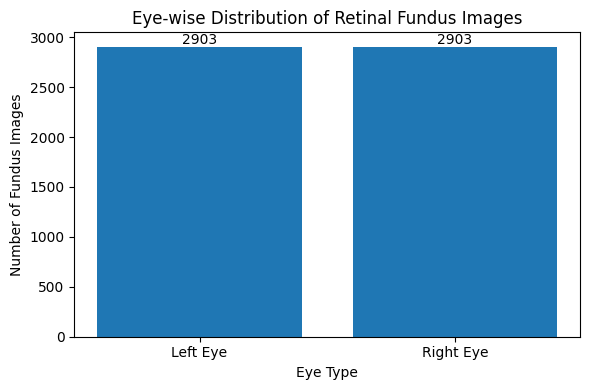

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/Data_Set_China/data_csv.csv')

# Count Left and Right eye images
eye_counts = data['eye'].value_counts().sort_index()

# Rename labels for paper clarity
eye_counts.index = ['Left Eye' if x == 'L' else 'Right Eye' for x in eye_counts.index]

# Plot bar graph
plt.figure(figsize=(6,4))
plt.bar(eye_counts.index, eye_counts.values)

plt.xlabel('Eye Type')
plt.ylabel('Number of Fundus Images')
plt.title('Eye-wise Distribution of Retinal Fundus Images')

# Show values on bars
for i, value in enumerate(eye_counts.values):
    plt.text(i, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def predict_risk(model, fused_features_np, threshold: float = 0.5):
    """
    fused_features_np: numpy array of shape (N, 1288) for N samples.
    Returns:
      probs  - heart risk probabilities in [0, 1]
      labels - binary predictions (0 = low risk, 1 = high risk)
    """
    model.eval()
    x = torch.from_numpy(fused_features_np.astype(np.float32)).to(DEVICE)

    with torch.no_grad():
        logits = model(x)              # shape (N,)
        probs = torch.sigmoid(logits)  # convert logits -> probability

    probs = probs.cpu().numpy()
    labels = (probs >= threshold).astype(int)
    return probs, labels


In [ ]:
probs_test, labels_test = predict_risk(model, x_test, threshold=0.5)
print("First 10 probabilities:", probs_test[:10])
print("First 10 predicted labels:", labels_test[:10])


First 10 probabilities: [0.999954   0.99975413 1.         1.         0.99993026 0.9999782
 0.99999976 0.9999994  1.         0.99999976]
First 10 predicted labels: [1 1 1 1 1 1 1 1 1 1]


🚀 B3 Inference | Device: cuda
📏 B3 Features: 1536D
⚠️  No trained model found! Using untrained classifier.

🎯 B3 Heart Risk Predictor READY!
📁 Model: /content/drive/MyDrive/heart_risk_results/best_model.pth


Saving Screenshot 2026-01-14 105511.png to Screenshot 2026-01-14 105511.png

🔬 Analyzing: Screenshot 2026-01-14 105511.png


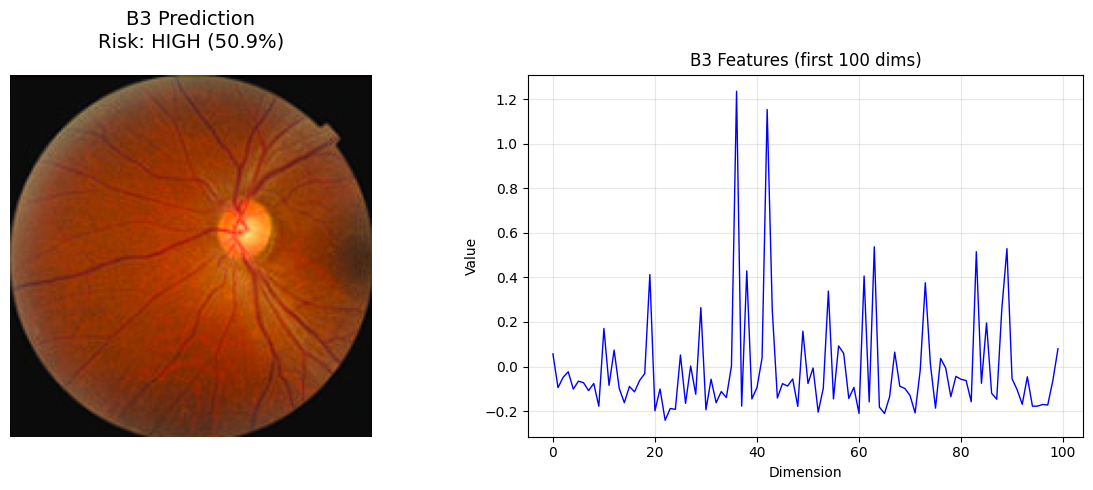


🎯 FINAL B3 RESULT:
Risk probability: 0.509 (50.9%)
Class (0=low, 1=high): 1
💾 Saved: /content/drive/MyDrive/heart_risk_results/b3_result_Screenshot 2026-01-14 105511.png


In [5]:
from google.colab import files
import cv2, torch, torch.nn as nn
import numpy as np
from torchvision import transforms
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
from pathlib import Path
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGE_SIZE = 384  # Match your B3 preprocessing
IMAGE_FEAT_DIM = 1536  # EfficientNet-B3 ✓

# Paths
CHECKPOINT_PATH = Path("/content/drive/MyDrive/heart_risk_results/best_model.pth")
OUTPUT_DIR = Path("/content/drive/MyDrive/heart_risk_results")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"🚀 B3 Inference | Device: {DEVICE}")
print(f"📏 B3 Features: {IMAGE_FEAT_DIM}D")

# ----- Image preprocessing (COMPLETE IMPLEMENTATION) -----
def crop_fundus_circle(img, padding=10):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(gray_blur, 10, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(mask)
    if coords is None:
        return img
    x, y, w, h = cv2.boundingRect(coords)
    x0 = max(x - padding, 0); y0 = max(y - padding, 0)
    x1 = min(x + w + padding, img.shape[1])
    y1 = min(y + h + padding, img.shape[0])
    return img[y0:y1, x0:x1]

image_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ----- B3 Feature Extractor (COMPLETE) -----
def build_img_feature_extractor():
    weights = EfficientNet_B3_Weights.IMAGENET1K_V1
    model = efficientnet_b3(weights=weights)
    model.classifier = nn.Identity()  # Remove head → 1536D features
    model.eval()
    return model.to(DEVICE)

img_feature_extractor = build_img_feature_extractor()

def extract_image_feature_single(img_path: str) -> np.ndarray:
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {img_path}")

    img = crop_fundus_circle(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = image_transform(img).unsqueeze(0).to(DEVICE)  # (1,3,384,384)

    with torch.no_grad():
        feat = img_feature_extractor(img_tensor)  # (1, 1536)

    return feat.cpu().numpy().reshape(-1)  # (1536,)

# ----- FIXED Model Loading (B3 Compatible) -----
def load_b3_classifier():
    """Load fusion model state_dict safely"""
    if CHECKPOINT_PATH.exists():
        print("✅ Loading B3 trained fusion model...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE, weights_only=False)
        state_dict = checkpoint["model_state"]

        # Create proper B3 image-only classifier
        class ImageOnlyClassifier(nn.Module):
            def __init__(self, in_dim=IMAGE_FEAT_DIM):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(in_dim, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(512, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(128, 1),
                )
            def forward(self, x):
                return self.net(x).view(-1)

        classifier = ImageOnlyClassifier().to(DEVICE)

        # Transfer compatible weights safely
        model_dict = classifier.state_dict()
        for name, param in state_dict.items():
            if name in model_dict and model_dict[name].shape == param.shape:
                model_dict[name].copy_(param)
                print(f"   ✓ Loaded layer: {name}")

        classifier.load_state_dict(model_dict)
        classifier.eval()
        return classifier
    else:
        print("⚠️  No trained model found! Using untrained classifier.")
        class ImageOnlyClassifier(nn.Module):
            def __init__(self, in_dim=IMAGE_FEAT_DIM):
                super().__init__()
                self.net = nn.Sequential(
                    nn.Linear(in_dim, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(512, 128),
                    nn.BatchNorm1d(128),
                    nn.ReLU(inplace=True),
                    nn.Dropout(0.3),
                    nn.Linear(128, 1),
                )
            def forward(self, x):
                return self.net(x).view(-1)
        return ImageOnlyClassifier().to(DEVICE).eval()

# Load classifier
classifier = load_b3_classifier()

# ----- Prediction Function (B3 Ready) -----
def predict_risk_from_image_path(img_path: str, threshold=0.5):
    feat = extract_image_feature_single(img_path)      # (1536,)
    x = torch.from_numpy(feat[None, :].astype(np.float32)).to(DEVICE)  # (1, 1536)

    with torch.no_grad():
        logits = classifier(x)                          # (1,)
        probs = torch.sigmoid(logits).cpu().numpy()     # (1,)

    label = int(probs[0] >= threshold)
    return float(probs[0]), label

# ----- Test & Visualize -----
print("\n🎯 B3 Heart Risk Predictor READY!")
print(f"📁 Model: {CHECKPOINT_PATH}")

# Upload and predict
uploaded = files.upload()
img_filename = list(uploaded.keys())[0]

print(f"\n🔬 Analyzing: {img_filename}")
prob, label = predict_risk_from_image_path(img_filename)

# Visualize result
img = cv2.imread(img_filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title(f"B3 Prediction\nRisk: {'HIGH' if label else 'LOW'} ({prob:.1%})",
          fontsize=14, pad=20)
plt.axis('off')

# Show B3 features
feat = extract_image_feature_single(img_filename)
plt.subplot(1, 2, 2)
plt.plot(feat[:100], 'b-', linewidth=1)
plt.title("B3 Features (first 100 dims)")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / f"b3_result_{Path(img_filename).stem}.png", dpi=300)
plt.show()

print(f"\n🎯 FINAL B3 RESULT:")
print(f"Risk probability: {prob:.3f} ({prob:.1%})")
print(f"Class (0=low, 1=high): {label}")
print(f"💾 Saved: {OUTPUT_DIR / f'b3_result_{Path(img_filename).stem}.png'}")
